In [1]:
import torch, torchvision
import torch.nn.functional as ff
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
#Configuration & Loading MNIST:
batch_size = 20

transform_src = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,)),])    #zero mean, unit variance

training_set = datasets.MNIST('./data/', train=True, download=True, transform=transform_src)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

testing_set = datasets.MNIST('./data/', train=False, download=True, transform=transform_src)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle=True)

In [3]:
#Building the model:
class ConvNetwork(nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(2,2)

        self.drop = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 10)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, img):
        x = self.relu(self.conv1(img))
        x = self.relu(self.conv2(x)) 
        x = self.maxpool(x)
        x = self.drop(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = img.view(x.size(0), -1)        #Flatten
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.softmax(x)
        return x

net = ConvNetwork()

In [4]:
print(net)

ConvNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
)


In [5]:
#Training the model:
cross_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
time0 = time()
epochs = 40
training_loss = []

for epoch in range(epochs):
    step_loss = []
    net.train()
    running_loss = 0
    for data in training_loader:
        x, y = data
        y_hot = ff.one_hot(y, num_classes=10) 
        optimizer.zero_grad()
        output = net(x)
        loss = cross_loss(output, y_hot.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  
        step_loss.append(loss.item())
    else:
        print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(training_loader)))
        training_loss.append(np.array(step_loss).mean())
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.037868060072263
Epoch 1 - Training loss: 1.8953118424018225
Epoch 2 - Training loss: 1.8439098089138666
Epoch 3 - Training loss: 1.7958259309530258
Epoch 4 - Training loss: 1.7590111271937687
Epoch 5 - Training loss: 1.7475062317450842
Epoch 6 - Training loss: 1.7401402361392975
Epoch 7 - Training loss: 1.734981418689092
Epoch 8 - Training loss: 1.7310632025400798
Epoch 9 - Training loss: 1.7271895480155945
Epoch 10 - Training loss: 1.7246968974669774
Epoch 11 - Training loss: 1.7225904551347098
Epoch 12 - Training loss: 1.7194843015670775
Epoch 13 - Training loss: 1.717911062081655
Epoch 14 - Training loss: 1.7156969537734985
Epoch 15 - Training loss: 1.7133571644624075
Epoch 16 - Training loss: 1.7127070597012837
Epoch 17 - Training loss: 1.711055784145991
Epoch 18 - Training loss: 1.708871782064438
Epoch 19 - Training loss: 1.7083798082272212
Epoch 20 - Training loss: 1.7068174517552057
Epoch 21 - Training loss: 1.705331088701884
Epoch 22 - Training loss: 

In [6]:
#Testing the model:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    time00 = time()
    loss = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss(output, target).item()    #sum up batch loss
            pred = output.argmax(1, keepdim=True)        #get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
         correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print("\nTesting Time (in seconds) =",(time()-time00))

In [7]:
test(net, testing_loader)


Test set: Accuracy: 7536/10000 (75%)


Testing Time (in seconds) = 16.448195934295654


<function matplotlib.pyplot.show(close=None, block=None)>

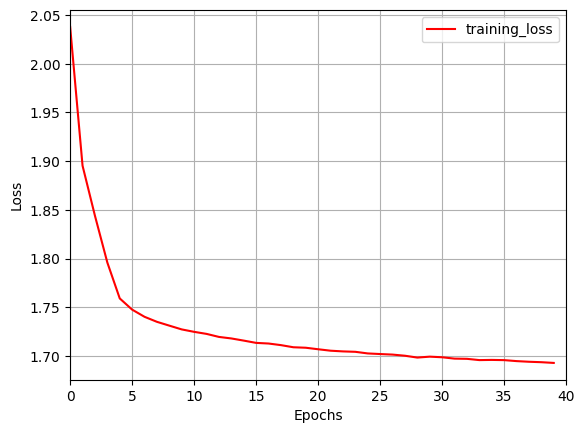

In [9]:
#Plotting:
plt.plot(training_loss, label='training_loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 40)
plt.legend()
plt.grid(True)
plt.show